# Kerchunk a Single SalishSeaCast netCDF File

Scan a single SalishSeaCast netCDF file to create a Kerchunk virtual dataset and use the dataset
in `xarray` via `fsspec`. This notebook is guided by the Kerchunk Basics notebook in Project Pythia
Kerchunk Cookbook.

ref: https://zenodo.org/badge/latestdoi/588661659

In [1]:
import os
from pathlib import Path

import fsspec
import kerchunk.hdf
import ujson
import xarray

In [2]:
nc_path = Path(
    "/results2/SalishSea/nowcast-green.202111/01jan07/SalishSea_1h_20070101_20070101_grid_T.nc"
)

nc_path.exists()

True

Parse the netCDF file to collect data byte ranges,
compression information,
and metadata attributes.
Then, translate that information into Zarr format and store it as a Kerchunk
.json reference file.

In [3]:
with fsspec.open(nc_path) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, os.fspath(nc_path))
    with open("kerchunk.json", "wb") as outf:
        outf.write(ujson.dumps(h5chunks.translate()).encode())


The low level way to load the dataset is to create a filesystem from the Kerchunk reference file,
create a mapper from that,
and open the `xarray` dataset using the `zarr` engine.

In [4]:
fs = fsspec.filesystem(
    "reference",
    fo="kerchunk.json",
)
ds = xarray.open_dataset(
    fs.get_mapper(""),
    engine="zarr",
    backend_kwargs={"consolidated": False},
)

ds

<xarray.Dataset> Size: 6GB
Dimensions:               (y: 898, x: 398, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (y, x) float32 1MB ...
    nav_lon               (y, x) float32 1MB ...
    time_centered         (time_counter) datetime64[ns] 192B ...
  * time_counter          (time_counter) datetime64[ns] 192B 2007-01-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (y, x) float32 1MB ...
    bounds_lat            (y, x, nvertex) float32 6MB ...
    bounds_lon            (y, x, nvertex) float32 6MB ...
    deptht_bounds         (deptht, axis_nbounds) float32 320B ...
    e3t                   (time_counter, deptht, y, x) float32 1GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 1GB ...
    sossheig              (time_counter, y, x) float32 34MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    vosaline              (time_counter, deptht, y, x) float32 1GB ...
    votemper              (time_counter, deptht, y, x) float32 1GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

At a higher level,
Kerchunk provides a engine backend for `xarray` that hides most of the details above.
The `open_dataset_options={"chunks": {}}` argument causes `xarray` to load the dataset with `dask`
using the chunks specified in the Kerchunk reference file.

In [5]:
ds2 = xarray.open_dataset(
    "kerchunk.json",
    engine="kerchunk",
    open_dataset_options={"chunks": {}},
)

ds2

<xarray.Dataset> Size: 6GB
Dimensions:               (y: 898, x: 398, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
  * deptht                (deptht) float32 160B 0.5 1.5 2.5 ... 414.5 441.5
    nav_lat               (y, x) float32 1MB ...
    nav_lon               (y, x) float32 1MB ...
    time_centered         (time_counter) datetime64[ns] 192B ...
  * time_counter          (time_counter) datetime64[ns] 192B 2007-01-01T00:30...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area                  (y, x) float32 1MB ...
    bounds_lat            (y, x, nvertex) float32 6MB ...
    bounds_lon            (y, x, nvertex) float32 6MB ...
    deptht_bounds         (deptht, axis_nbounds) float32 320B ...
    e3t                   (time_counter, deptht, y, x) float32 1GB ...
    sigma_theta           (time_counter, deptht, y, x) float32 1GB ...
    sossheig              (time_counter, y, x) float32 34MB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    vosaline              (time_counter, deptht, y, x) float32 1GB ...
    votemper              (time_counter, deptht, y, x) float32 1GB ...
Attributes:
    Conventions:  CF-1.6
    description:  physics tracers and VVL layer thicknesses
    name:         SalishSea_1h_20070101_20070105
    timeStamp:    2022-Oct-24 21:24:51 GMT
    title:        physics tracers and VVL layer thicknesses
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

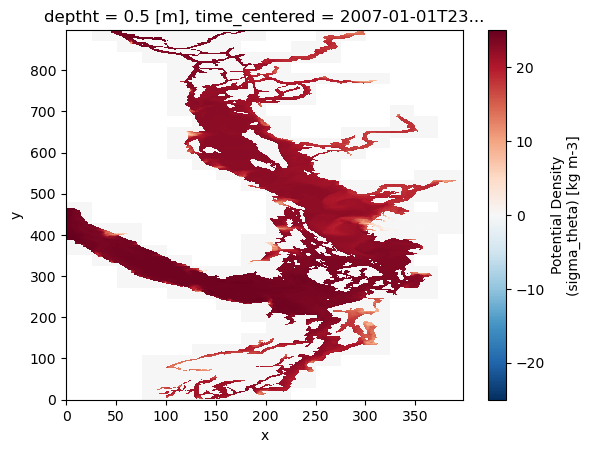

In [6]:
ds2.sigma_theta.isel(time_counter=-1, deptht=0).plot()